## Augmentation on Human vs Horse classification:

Courser Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%204%20-%20Lesson%204%20-%20Notebook.ipynb

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
  
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()


# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_horse_names = os.listdir(train_horse_dir)
print(len(train_horse_names))

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')
train_human_names = os.listdir(train_human_dir)
print(len(train_human_names))

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
validation_horse_names = os.listdir(validation_horse_dir)
print(len(validation_horse_names))

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')
validation_human_names = os.listdir(validation_human_dir)
print(len(validation_human_names))


--2020-03-18 09:06:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  80.0MB/s    in 1.8s    

2020-03-18 09:06:32 (80.0 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-03-18 09:06:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zi

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

img_size = 300


model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()



from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])



TensorFlow 2.x selected.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (N

In [3]:
# Imagegenerator with Augmentation:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.20,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',
    target_size=(img_size, img_size),
    batch_size=128,
    class_mode='binary'  # Since we use binary_crossentropy loss, we need binary labels
)

# Flow validation images in batches of 128
val_generator = val_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human/',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    target=0.95
    if (logs['accuracy']>target):
      print('Reached %0.1f%% training accuracty. Training converged!' %(target*100))
      self.model.stop_training=True

callback = myCallback()


history =  model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    epochs = 20,
    callbacks=[callback],
    validation_data = val_generator,
    validation_steps=val_generator.n//val_generator.batch_size,
    verbose=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 8 steps
Epoch 1/20
8/8 [==============================] - 24s 3s/step - loss: 2.9764 - accuracy: 0.5083 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 23s 3s/step - loss: 0.7106 - accuracy: 0.5061 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/20
8/8 [==============================] - 23s 3s/step - loss: 0.6909 - accuracy: 0.5673 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 4/20
8/8 [==============================] - 23s 3s/step - loss: 0.6683 - accuracy: 0.6240 - val_loss: 0.8889 - val_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 23s 3s/step - loss: 0.5691 - accuracy: 0.6752 - val_loss: 0.6179 - val_accuracy: 0.5469
Epoch 6/20
8/8 [==============================] - 23s 3s/step - loss: 2.4775 - accuracy: 0.7286 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 7/20
8/8 [==============================] - 23s 3s/step - loss: 0.7106 - acc

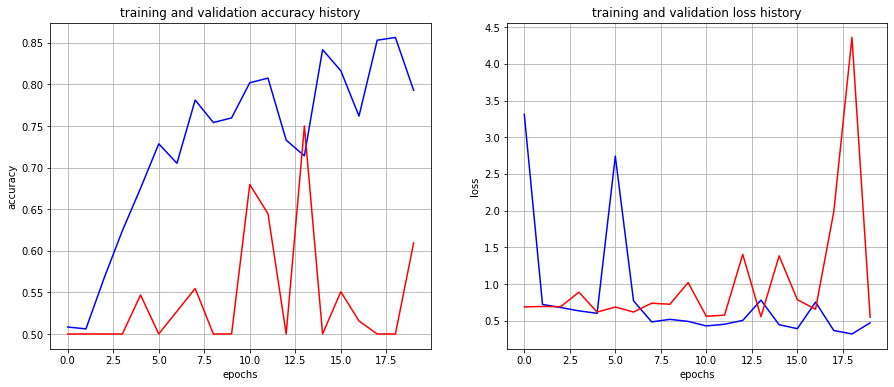

In [9]:
# Model history:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

# plotting trianing history:
plt.figure(figsize=(15,6))  # plt.figure() 
plt.subplot(1,2,1)
plt.plot(acc,'b', label='training accuracy')
plt.plot(val_acc,'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training and validation accuracy history')
plt.grid()
# plt.show()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(loss,'b', label='training loss')
plt.plot(val_loss,'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training and validation loss history')
plt.grid()
plt.show()

In [0]:
# Clean-up:
import os, signal

os.kill( os.getpid(), signal.SIGKILL )